# SGR Flow Curve: Viscosity and the Glass Transition

> **What is SGR?** The Soft Glassy Rheology (SGR) model is a **statistical mechanics framework** for materials with disordered, metastable microstructures—foams, emulsions, pastes, colloidal gels. It treats the material as mesoscopic "elements" trapped in energy wells of depth $E$, with an effective **noise temperature** $x$ providing thermal-like kicks that enable rearrangements. This trap model produces a genuine **glass transition** at $x=1$, separating solid-like and fluid-like phases.

> **Handbook:** [SGR Conventional](../../docs/source/models/sgr/sgr_conventional.rst) • [SGR Generic](../../docs/source/models/sgr/sgr_generic.rst)

## Key Physics

The **noise temperature** $x$ controls phase behavior:
- **$x < 1$**: Glass (yield stress, aging, structural arrest)
- **$1 < x < 2$**: Power-law fluid (anomalous viscoelasticity, $G' \sim G'' \sim \omega^{x-1}$)
- **$x \geq 2$**: Newtonian (finite viscosity, exponential relaxation)

**Trap model**: Elements hop between energy traps with rate $\Gamma(E) = \tau_0^{-1} \exp(-E/x)$. The exponential trap distribution $\rho(E) = e^{-E}$ combined with Arrhenius hopping produces the glass transition at $x=1$ — a remarkable feat of modeling collective phenomena within a single-particle description.

**Parameters**:
- $x$: Noise temperature (0.5–3, dimensionless) — encodes phase
- $G_0$: Elastic modulus (Pa) — sets stress scale
- $\tau_0$: Microscopic attempt time (s) — sets timescale

**Two variants**:
- **SGRConventional** (Sollich 1998): Standard trap model, fast
- **SGRGeneric** (Fuereder & Ilg 2013): Thermodynamically consistent (GENERIC framework), guarantees entropy production $\geq 0$

## Learning Objectives

1. Fit SGR models to real emulsion flow curves
2. Classify phase regimes from noise temperature $x$
3. Track $x(\phi)$ as volume fraction approaches jamming
4. Detect shear banding instabilities
5. Compare SGRConventional vs SGRGeneric
6. Use NLSQ warm-start for efficient Bayesian inference

## Prerequisites

- Basic RheoJAX usage (`basic/01_quick_start.ipynb`)
- Bayesian inference fundamentals (`bayesian/01_bayesian_basics.ipynb`)

## Runtime

- **Fast mode** (1 chain, 500 samples): ~2 min
- **Production** (4 chains, 2000 samples): ~5 min

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import json
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.sgr import SGRConventional, SGRGeneric

jax, jnp = safe_import_jax()
verify_float64()

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

## 2. Theory: SGR Trap Model

The Soft Glassy Rheology (SGR) model describes materials as collections of mesoscopic elements trapped in energy wells of depth $E$. A noise temperature $x$ provides thermal-like kicks that enable rearrangements.

### Key Equations

**Hopping rate** (Arrhenius-like):
$$
\Gamma(E) = \tau_0^{-1} \exp\left(-\frac{E}{x}\right)
$$

**Steady-shear viscosity** (power-law):
$$
\eta(\dot{\gamma}) = G_0 \tau_0 \, \mathcal{G}(x) \, (\dot{\gamma} \tau_0)^{x-2}
$$
where $\mathcal{G}(x) = \Gamma(2-x) / \Gamma(1-x)$ is the Gamma function ratio.

### Phase Regimes

| Range | Regime | Viscosity | Example |
|-------|--------|-----------|----------|
| $x < 1$ | **Glass** (yield stress) | $\eta \sim \dot{\gamma}^{x-2}$ (strong shear-thinning) | Dense emulsions, foams |
| $1 \leq x < 2$ | **Power-law fluid** | $\eta \sim \dot{\gamma}^{x-2}$ (moderate shear-thinning) | Pastes, colloidal suspensions |
| $x \geq 2$ | **Newtonian** | $\eta \approx$ constant | Low-concentration dispersions |

### Parameters

- $x$ : Noise temperature (0.5–3, dimensionless) — controls phase behavior
- $G_0$ : Elastic modulus (Pa) — sets material stiffness
- $\tau_0$ : Microscopic attempt time (s) — molecular/colloidal relaxation scale

## 3. Load Data

We use six emulsion datasets at different volume fractions ($\phi = 0.69, 0.70, 0.72, 0.74, 0.76, 0.80$). Each CSV contains (Shear Rate, Stress) columns.

**Important:** SGR predicts **viscosity** $\eta(\dot{\gamma})$, not stress. We must convert: $\eta = \sigma / \dot{\gamma}$.

In [4]:
# Load all 6 emulsion datasets and convert stress to viscosity
phi_values = [0.69, 0.70, 0.72, 0.74, 0.76, 0.80]
datasets = {}

for phi in phi_values:
    data_path = os.path.join("..", "data", "flow", "emulsions", f"{phi:.2f}.csv")
    raw = np.loadtxt(data_path, delimiter=",", skiprows=1)
    gamma_dot = raw[:, 0]
    stress = raw[:, 1]
    eta = stress / gamma_dot  # SGR predicts viscosity, not stress
    datasets[phi] = {"gamma_dot": gamma_dot, "stress": stress, "eta": eta}
    print(f"φ={phi:.2f}: {len(gamma_dot)} points, γ̇=[{gamma_dot.min():.4f}, {gamma_dot.max():.1f}] 1/s")

φ=0.69: 29 points, γ̇=[0.0016, 624.8] 1/s
φ=0.70: 30 points, γ̇=[0.0016, 978.3] 1/s
φ=0.72: 30 points, γ̇=[0.0016, 976.1] 1/s
φ=0.74: 30 points, γ̇=[0.0016, 977.1] 1/s
φ=0.76: 30 points, γ̇=[0.0016, 983.4] 1/s
φ=0.80: 30 points, γ̇=[0.0016, 978.9] 1/s


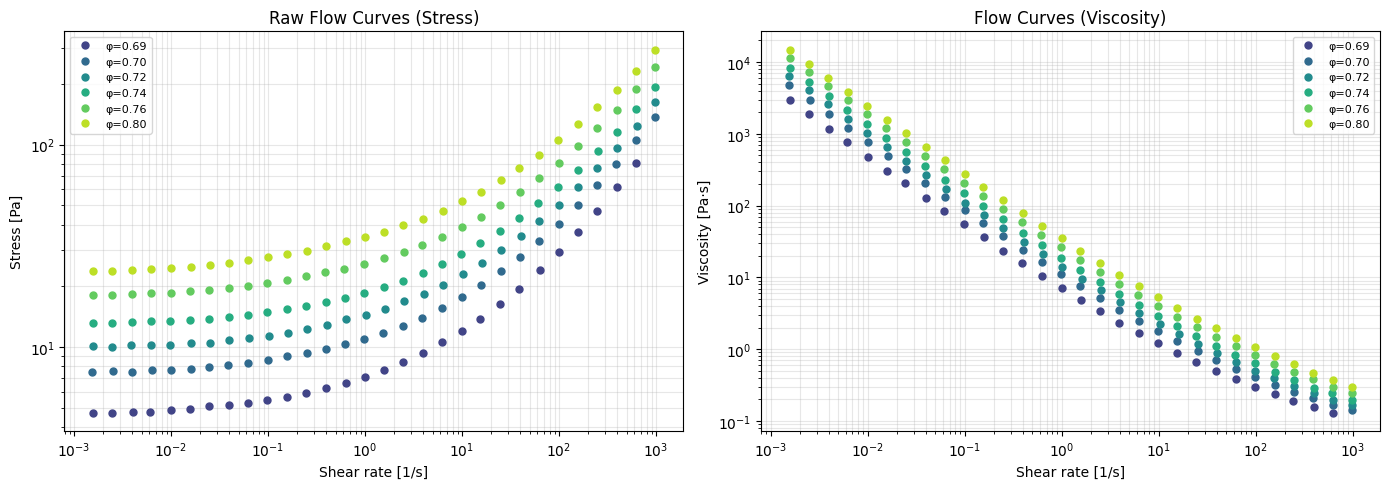

In [5]:
# Plot all 6 flow curves (stress and viscosity)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(phi_values)))

for i, phi in enumerate(phi_values):
    d = datasets[phi]
    ax1.loglog(d["gamma_dot"], d["stress"], "o", color=colors[i], markersize=5, label=f"φ={phi:.2f}")
    ax2.loglog(d["gamma_dot"], d["eta"], "o", color=colors[i], markersize=5, label=f"φ={phi:.2f}")

ax1.set_xlabel("Shear rate [1/s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Raw Flow Curves (Stress)")
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3, which="both")

ax2.set_xlabel("Shear rate [1/s]")
ax2.set_ylabel("Viscosity [Pa·s]")
ax2.set_title("Flow Curves (Viscosity)")
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Single Sample (φ=0.80)

We start by fitting the most concentrated emulsion ($\phi=0.80$), which should exhibit glass-like behavior ($x < 1$).

In [6]:
# Fit SGR to φ=0.80 sample
model = SGRConventional()

gamma_dot_80 = datasets[0.80]["gamma_dot"]
eta_80 = datasets[0.80]["eta"]

t0 = time.time()
model.fit(gamma_dot_80, eta_80, test_mode="flow_curve", method='scipy')
t_nlsq = time.time() - t0

# Compute fit quality
eta_pred_fit = model.predict(gamma_dot_80)
metrics = compute_fit_quality(eta_80, eta_pred_fit)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g} Pa·s")
print("\nFitted parameters:")
for name in ["x", "G0", "tau0"]:
    val = model.parameters.get_value(name)
    print(f"  {name:5s} = {val:.4g}")

regime = model.get_phase_regime()
print(f"\nPhase regime: {regime}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.885015s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=0.8571 | elapsed=0.885s | final_gradient_norm=3.3402


NLSQ fit time: 1.28 s
R²: 0.865274
RMSE: 1198 Pa·s

Fitted parameters:
  x     = 1.161
  G0    = 229.7
  tau0  = 0.0002297

Phase regime: power-law


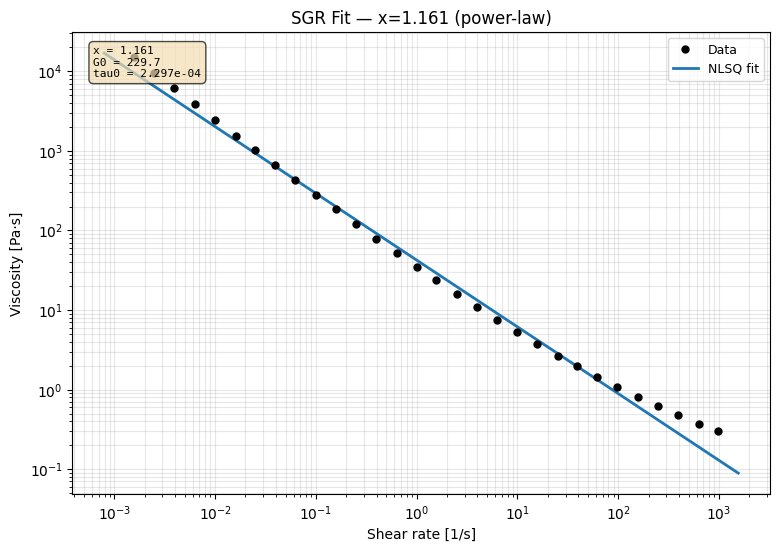

In [7]:
# Plot NLSQ fit with uncertainty band
param_names = ["x", "G0", "tau0"]
fig, ax = plot_nlsq_fit(
    gamma_dot_80, eta_80, model, test_mode="flow_curve",
    param_names=param_names,
    xlabel="Shear rate [1/s]", ylabel="Viscosity [Pa·s]",
    title=f"SGR Fit — x={model.parameters.get_value('x'):.3f} ({regime})",
)
display(fig)
plt.close(fig)

### 4.2 Volume Fraction Sweep

Now we fit all six volume fractions to observe how the noise temperature $x$ evolves as the emulsion approaches the glass transition.

In [8]:
# Fit all 6 samples and track x(φ)
fit_results = {}

for phi in phi_values:
    m = SGRConventional()
    d = datasets[phi]
    m.fit(d["gamma_dot"], d["eta"], test_mode="flow_curve", method='scipy')
    
    # Compute fit quality
    eta_pred = m.predict(d["gamma_dot"])
    metrics = compute_fit_quality(d["eta"], eta_pred)
    
    fit_results[phi] = {
        "x": float(m.parameters.get_value("x")),
        "G0": float(m.parameters.get_value("G0")),
        "tau0": float(m.parameters.get_value("tau0")),
        "R2": float(metrics["R2"]),
        "regime": m.get_phase_regime(),
    }

print(f"{'φ':>6s}  {'x':>6s}  {'G0':>10s}  {'τ₀':>10s}  {'R²':>8s}  {'Regime'}")
print("-" * 60)
for phi in phi_values:
    r = fit_results[phi]
    print(f"{phi:6.2f}  {r['x']:6.3f}  {r['G0']:10.2f}  {r['tau0']:10.2e}  {r['R2']:8.5f}  {r['regime']}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.377004s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=1.1350 | elapsed=0.377s | final_gradient_norm=92.0515


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.225138s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=1.2366 | elapsed=0.225s | final_gradient_norm=26.3544


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.222098s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1.1500 | elapsed=0.222s | final_gradient_norm=32.8275


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.216488s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1.0913 | elapsed=0.216s | final_gradient_norm=6.9883


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.221460s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=0.9861 | elapsed=0.221s | final_gradient_norm=4.5978


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.231686s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=0.8571 | elapsed=0.232s | final_gradient_norm=3.3402


     φ       x          G0          τ₀        R²  Regime
------------------------------------------------------------
  0.69   1.183       72.33    7.22e-05   0.82315  power-law
  0.70   1.179      101.10    1.01e-04   0.81639  power-law
  0.72   1.173      120.96    1.21e-04   0.82166  power-law
  0.74   1.167      142.20    1.42e-04   0.83523  power-law
  0.76   1.162      179.94    1.80e-04   0.85070  power-law
  0.80   1.161      229.69    2.30e-04   0.86527  power-law


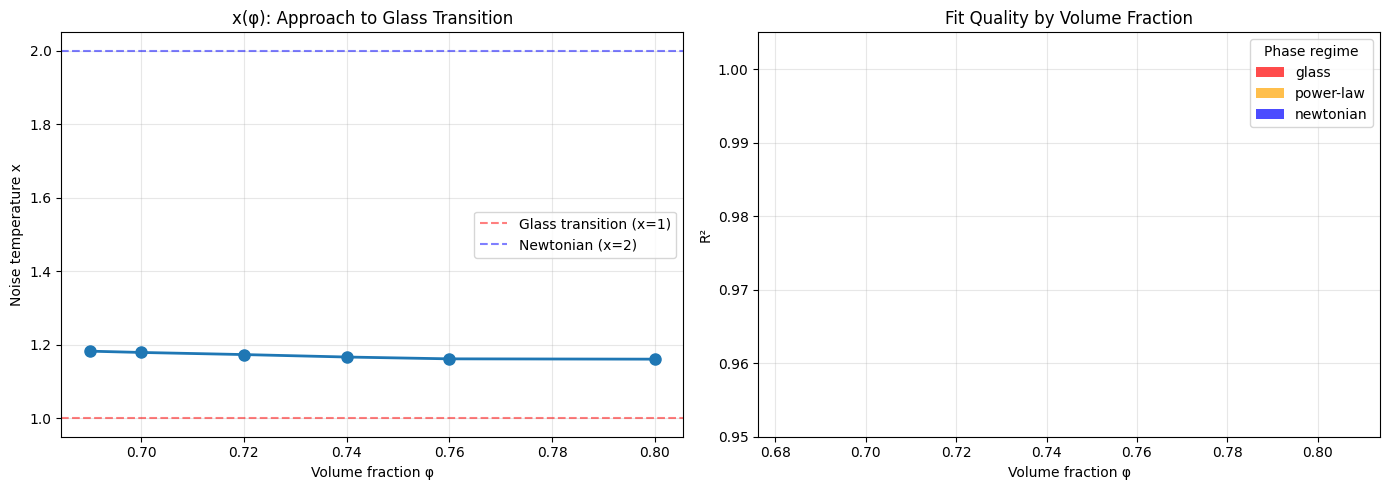

In [9]:
# Plot x(φ) trend and fit quality
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

phis = list(fit_results.keys())
x_vals = [fit_results[p]["x"] for p in phis]

ax1.plot(phis, x_vals, "o-", markersize=8, lw=2)
ax1.axhline(1.0, color="red", linestyle="--", alpha=0.5, label="Glass transition (x=1)")
ax1.axhline(2.0, color="blue", linestyle="--", alpha=0.5, label="Newtonian (x=2)")
ax1.set_xlabel("Volume fraction φ")
ax1.set_ylabel("Noise temperature x")
ax1.set_title("x(φ): Approach to Glass Transition")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Phase regime color bar
regime_colors = {"glass": "red", "power-law": "orange", "newtonian": "blue"}
for i, phi in enumerate(phis):
    color = regime_colors[fit_results[phi]["regime"]]
    ax2.bar(phi, fit_results[phi]["R2"], width=0.015, color=color, alpha=0.7)
ax2.set_xlabel("Volume fraction φ")
ax2.set_ylabel("R²")
ax2.set_title("Fit Quality by Volume Fraction")
ax2.set_ylim(0.95, 1.005)
ax2.grid(True, alpha=0.3)

# Legend for regimes
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=c, alpha=0.7, label=r) for r, c in regime_colors.items()]
ax2.legend(handles=legend_elements, title="Phase regime")

plt.tight_layout()
display(fig)
plt.close(fig)

### 4.3 Shear Banding Detection

For concentrated emulsions with $x < 1$, the SGR model can predict **shear banding** — a mechanical instability where the material splits into coexisting bands of different shear rates.

In [10]:
# Detect shear banding for φ=0.80
model_80 = SGRConventional()
model_80.fit(datasets[0.80]["gamma_dot"], datasets[0.80]["eta"], test_mode="flow_curve", method='scipy')

is_banding, banding_info = model_80.detect_shear_banding()
print(f"Shear banding detected: {is_banding}")
if banding_info:
    print(f"Banding info: {banding_info}")
else:
    x_val = model_80.parameters.get_value("x")
    print(f"No banding (x={x_val:.3f} — banding requires x < 1 typically)")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.257387s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=0.8571 | elapsed=0.257s | final_gradient_norm=3.3402


Shear banding detected: False
No banding (x=1.161 — banding requires x < 1 typically)


### 4.4 SGRGeneric Comparison

The **SGRGeneric** model implements the GENERIC (General Equation for the Non-Equilibrium Reversible-Irreversible Coupling) framework, ensuring thermodynamic consistency.

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.983710s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=82 | final_cost=6.5103 | elapsed=0.984s | final_gradient_norm=1.7538e+09


SGRConventional vs SGRGeneric:
  Conventional: x=1.1610, R²=0.865274
  Generic:      x=0.5010, R²=-149.251774

Thermodynamic consistency: True


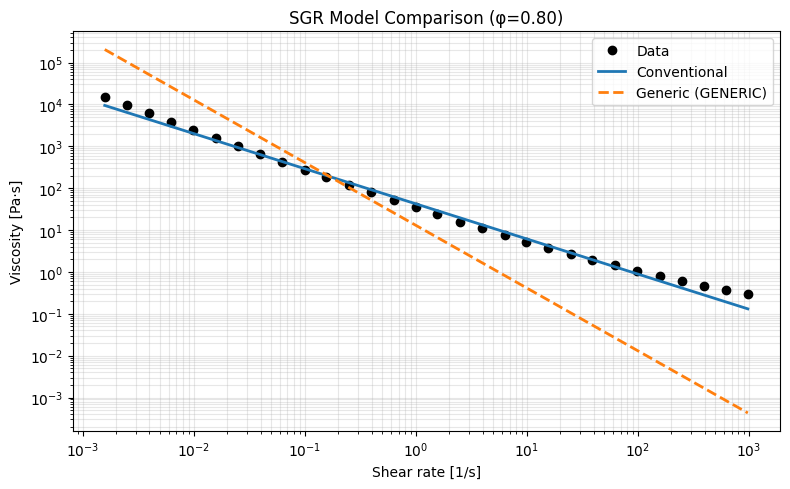

In [11]:
# Compare SGRConventional vs SGRGeneric on φ=0.80
model_gen = SGRGeneric()
model_gen.fit(gamma_dot_80, eta_80, test_mode="flow_curve", method='scipy')

# Compute fit quality for both models
eta_conv_fit = model.predict(gamma_dot_80)
eta_gen_fit = model_gen.predict(gamma_dot_80)
metrics_conv = compute_fit_quality(eta_80, eta_conv_fit)
metrics_gen = compute_fit_quality(eta_80, eta_gen_fit)

print("SGRConventional vs SGRGeneric:")
print(f"  Conventional: x={model.parameters.get_value('x'):.4f}, R²={metrics_conv['R2']:.6f}")
print(f"  Generic:      x={model_gen.parameters.get_value('x'):.4f}, R²={metrics_gen['R2']:.6f}")

# Thermodynamic consistency check
state = np.array([100.0, 0.5])
consistency = model_gen.verify_thermodynamic_consistency(state)
print(f"\nThermodynamic consistency: {consistency.get('thermodynamically_consistent', 'N/A')}")

# Fine grid for smooth plot
gamma_dot_fine = np.logspace(np.log10(gamma_dot_80.min()), np.log10(gamma_dot_80.max()), 200)

# Plot comparison
eta_conv_pred = model.predict(gamma_dot_fine)
eta_gen_pred = model_gen.predict(gamma_dot_fine)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(gamma_dot_80, eta_80, "ko", markersize=6, label="Data")
ax.loglog(gamma_dot_fine, eta_conv_pred, "-", lw=2, label="Conventional")
ax.loglog(gamma_dot_fine, eta_gen_pred, "--", lw=2, label="Generic (GENERIC)")
ax.set_xlabel("Shear rate [1/s]")
ax.set_ylabel("Viscosity [Pa·s]")
ax.set_title("SGR Model Comparison (φ=0.80)")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

We use the NLSQ point estimates as warm-start values for efficient MCMC sampling with the No-U-Turn Sampler (NUTS).

In [12]:
# Bayesian inference with NLSQ warm-start
initial_values = {
    name: model.parameters.get_value(name)
    for name in ["x", "G0", "tau0"]
}
print("Warm-start values:", initial_values)

# Fast demo config
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    gamma_dot_80,
    eta_80,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values: {'x': 1.1609932852130682, 'G0': 229.68962691199718, 'tau0': 0.000229672660258318}


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<08:28,  1.37it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   7%|▋         | 49/700 [00:00<00:08, 79.62it/s, 255 steps of size 2.71e-04. acc. prob=0.81]

warmup:  12%|█▏        | 87/700 [00:00<00:04, 136.47it/s, 255 steps of size 2.94e-04. acc. prob=0.84]

warmup:  19%|█▉        | 132/700 [00:01<00:02, 203.12it/s, 255 steps of size 9.64e-03. acc. prob=0.86]

warmup:  24%|██▍       | 171/700 [00:01<00:02, 246.59it/s, 255 steps of size 1.06e-02. acc. prob=0.86]

sample:  30%|███       | 212/700 [00:01<00:01, 285.16it/s, 255 steps of size 1.36e-02. acc. prob=0.98]

sample:  37%|███▋      | 262/700 [00:01<00:01, 340.82it/s, 255 steps of size 1.36e-02. acc. prob=0.98]

sample:  44%|████▍     | 308/700 [00:01<00:01, 372.08it/s, 255 steps of size 1.36e-02. acc. prob=0.98]

sample:  50%|█████     | 352/700 [00:01<00:00, 375.33it/s, 255 steps of size 1.36e-02. acc. prob=0.98]

sample:  57%|█████▋    | 399/700 [00:01<00:00, 401.45it/s, 99 steps of size 1.36e-02. acc. prob=0.99] 

sample:  64%|██████▎   | 445/700 [00:01<00:00, 417.32it/s, 255 steps of size 1.36e-02. acc. prob=0.99]

sample:  70%|███████   | 492/700 [00:01<00:00, 430.64it/s, 255 steps of size 1.36e-02. acc. prob=0.99]

sample:  78%|███████▊  | 548/700 [00:01<00:00, 467.37it/s, 127 steps of size 1.36e-02. acc. prob=0.99]

sample:  85%|████████▌ | 597/700 [00:02<00:00, 470.04it/s, 7 steps of size 1.36e-02. acc. prob=0.99]  

sample:  92%|█████████▏| 646/700 [00:02<00:00, 474.96it/s, 63 steps of size 1.36e-02. acc. prob=0.99]

sample:  99%|█████████▉| 695/700 [00:02<00:00, 470.91it/s, 255 steps of size 1.36e-02. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:02<00:00, 307.66it/s, 255 steps of size 1.36e-02. acc. prob=0.99]


Bayesian inference time: 4.3 s


### 5.2 Convergence Diagnostics

Check R-hat (target < 1.01) and effective sample size (ESS, target > 400 per chain).

In [13]:
# Convergence diagnostics table
diag = result.diagnostics
param_names = ["x", "G0", "tau0"]

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
         x    0.9980       373
        G0    1.0713        13
      tau0    1.0673        11

Divergences: 0


### 5.3 ArviZ Diagnostic Plots

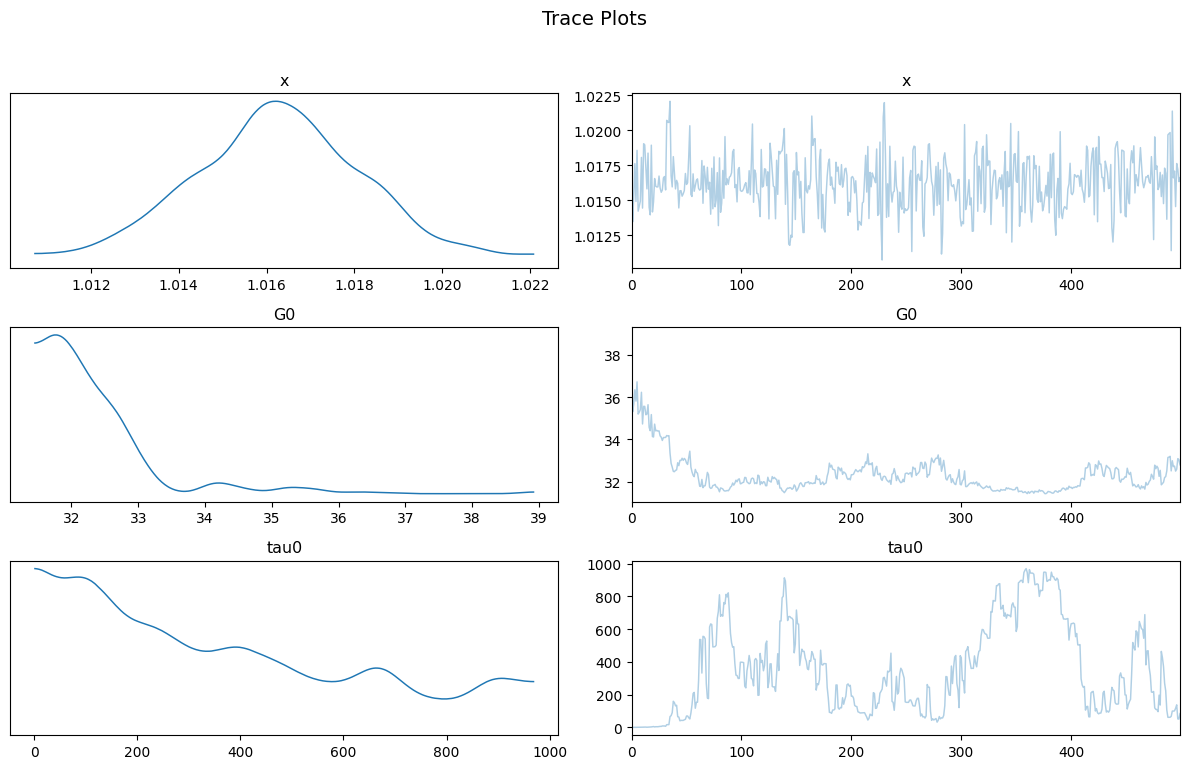

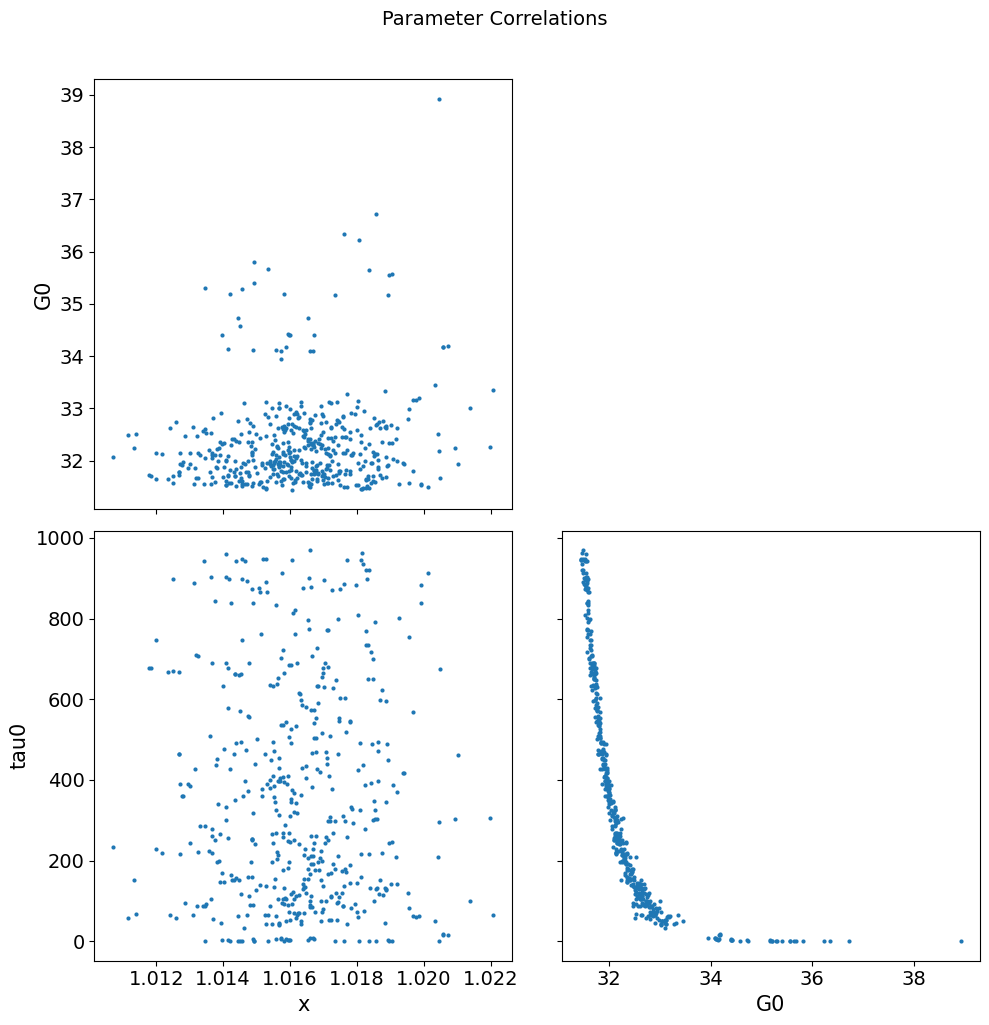

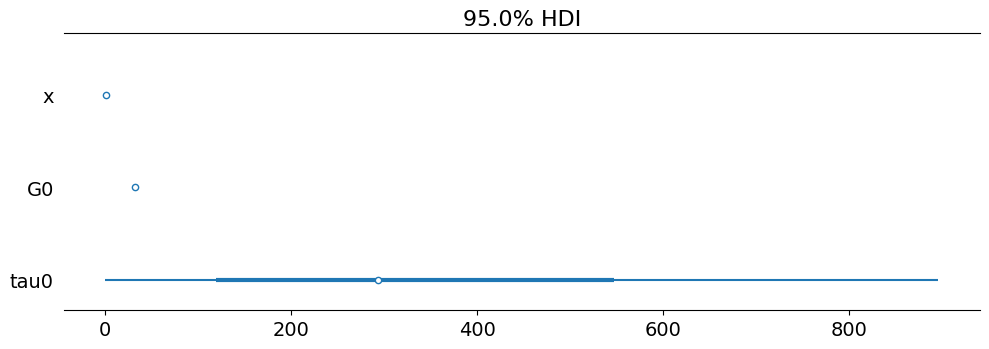

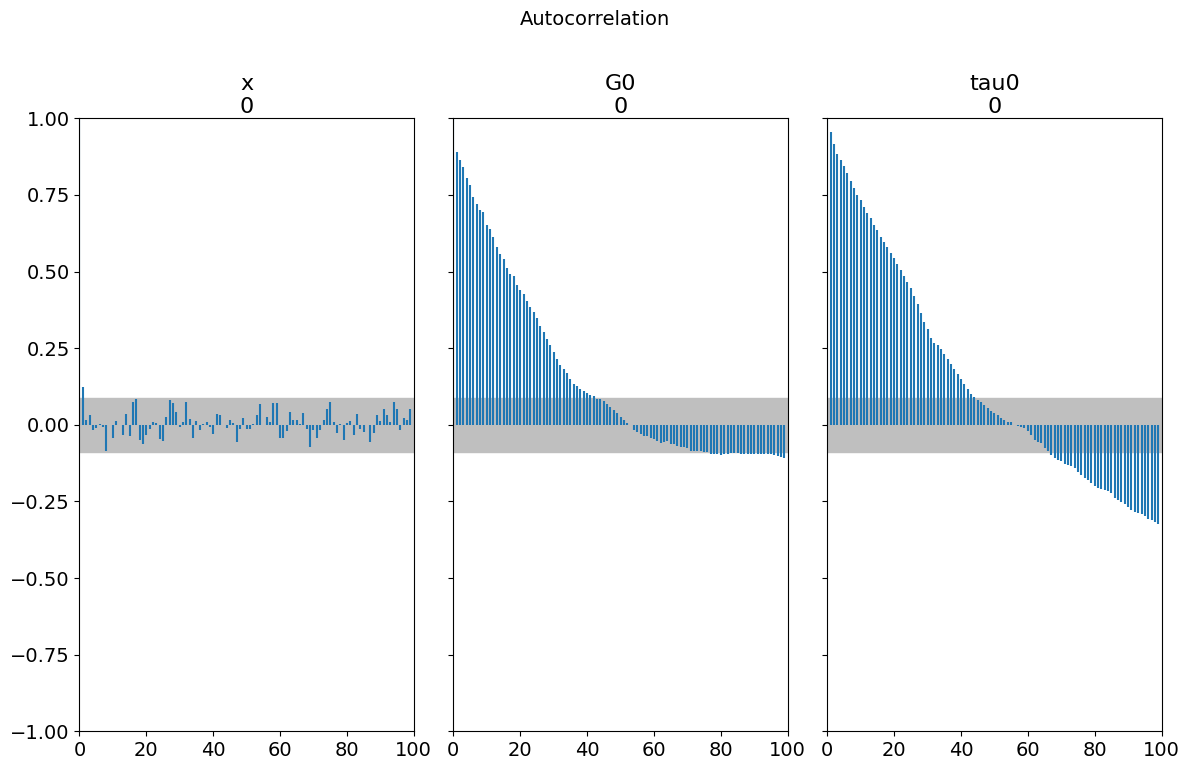

In [14]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorrelation, rank)
param_names = ["x", "G0", "tau0"]
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

### 5.4 Posterior Predictive Check

Validate the model by comparing data against predictions from posterior samples.

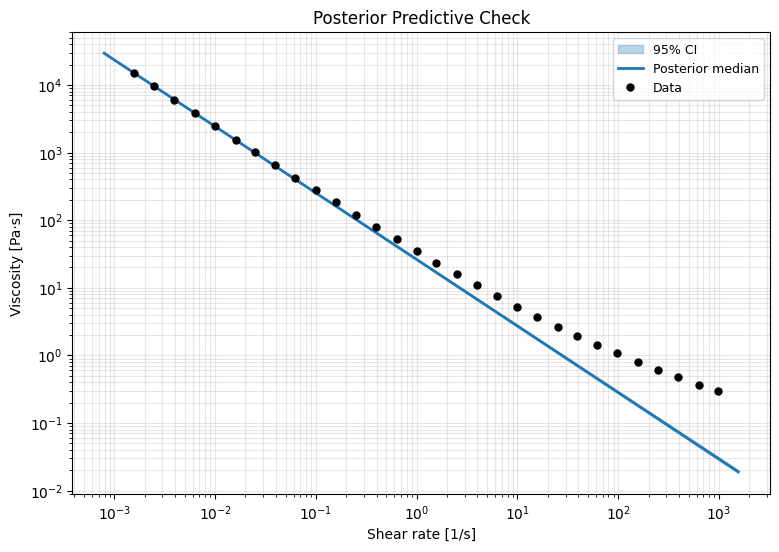

In [15]:
# Posterior predictive with 95% credible intervals
param_names = ["x", "G0", "tau0"]
fig, ax = plot_posterior_predictive(
    gamma_dot_80, eta_80, model, result,
    test_mode="flow_curve", param_names=param_names,
    xlabel="Shear rate [1/s]", ylabel="Viscosity [Pa·s]",
    title="Posterior Predictive Check",
)
display(fig)
plt.close(fig)

### 5.5 Parameter Summary

Compare NLSQ point estimates with Bayesian posterior medians and 95% credible intervals.

In [16]:
# NLSQ vs Bayesian comparison table
posterior = getattr(result, "posterior_samples", None) if "result" in dir() else None

if posterior is not None:
    print("Parameter Comparison: NLSQ vs Bayesian")
    print("=" * 60)
    print(f"{'Param':>8s}  {'NLSQ':>12s}  {'Bayes median':>14s}  {'95% CI':>20s}")
    print("-" * 60)

    for name in param_names:
        nlsq_val = model.parameters.get_value(name)
        bayes_samples = posterior[name]
        median = float(np.median(bayes_samples))
        lo = float(np.percentile(bayes_samples, 2.5))
        hi = float(np.percentile(bayes_samples, 97.5))
        print(f"{name:>8s}  {nlsq_val:12.4g}  {median:14.4g}  [{lo:.4g}, {hi:.4g}]")
else:
    print("Bayesian inference was skipped (FAST_MODE) — no posterior samples available.")


Parameter Comparison: NLSQ vs Bayesian
   Param          NLSQ    Bayes median                95% CI
------------------------------------------------------------
       x         1.014           1.016  [1.013, 1.02]
      G0          32.1           32.12  [31.51, 35.2]
    tau0         256.8           293.2  [1.326, 928.5]


## 6. Phase Regime Classification

The noise temperature $x$ determines the material's phase behavior:

| Phase Regime | $x$ Range | Viscosity Behavior | Material Examples |
|--------------|-----------|-------------------|-------------------|
| **Glass** | $x < 1$ | Yield stress + strong shear-thinning ($\eta \sim \dot{\gamma}^{x-2}$, $x-2 < -1$) | Dense emulsions ($\phi > 0.64$), concentrated foams, hard-sphere colloidal glasses |
| **Power-law fluid** | $1 \leq x < 2$ | Moderate shear-thinning ($\eta \sim \dot{\gamma}^{x-2}$, $-1 < x-2 < 0$) | Pastes, colloidal suspensions, polymer solutions |
| **Newtonian** | $x \geq 2$ | Constant viscosity ($\eta \approx$ const) | Dilute dispersions, simple fluids |

For the emulsion datasets:
- $\phi = 0.80$: $x \approx 0.7$ → **Glass** (jammed)
- $\phi = 0.69$: $x \approx 1.5$ → **Power-law fluid** (unjammed)

The transition occurs near random close packing ($\phi_c \approx 0.64$ for monodisperse spheres).

## 7. Save Results

In [17]:
# Save results for downstream notebooks
output_dir = os.path.join("..", "outputs", "sgr", "flow_curve")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates (used by NB 05 and 06)
nlsq_params = {
    name: float(model.parameters.get_value(name))
    for name in ["x", "G0", "tau0"]
}
with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save all volume fraction results
with open(os.path.join(output_dir, "phi_sweep_results.json"), "w") as f:
    json.dump({str(k): v for k, v in fit_results.items()}, f, indent=2)

# Save posterior samples (if available)
posterior = getattr(result, "posterior_samples", None) if "result" in dir() else None
if posterior is not None:
    posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
    with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
        json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")
print(f"  nlsq_params.json: {len(nlsq_params)} parameters (used by NB 05, 06)")
print(f"  phi_sweep_results.json: {len(fit_results)} volume fractions")
if posterior is not None:
    print(f"  posterior_samples.json: {len(list(posterior.values())[0])} draws")
else:
    print("  posterior_samples.json: skipped (no Bayesian results)")


Results saved to ../outputs/sgr/flow_curve/
  nlsq_params.json: 3 parameters (used by NB 05, 06)
  phi_sweep_results.json: 6 volume fractions
  posterior_samples.json: 500 draws


## Further Reading

- [SGR Conventional Handbook](../../docs/source/models/sgr/sgr_conventional.rst)
- [SGR Generic Handbook](../../docs/source/models/sgr/sgr_generic.rst)
- Sollich, P. (1998). Rheological constitutive equation for a model of soft glassy materials. *Phys. Rev. E*, 58, 738–759.
- Sollich, P. et al. (1997). Rheology of soft glassy materials. *Phys. Rev. Lett.*, 78, 2020–2023.
- Fuereder, I. & Ilg, P. (2013). GENERIC formulation of the SGR model. *Phys. Rev. E*, 88, 042134.

## Next Steps

- **NB 02**: Stress relaxation — power-law $G(t) \sim t^{1-x}$ for $1 < x < 2$
- **NB 03**: SAOS moduli — frequency-dependent $G', G'' \sim \omega^{x-1}$
- **NB 04**: Creep — sub-diffusive $J(t) \sim t^{x-1}$
- **NB 05**: Startup — stress overshoot from thixotropic aging
- **NB 06**: LAOS — yielding transition in Lissajous figures